# Notebook Overview 
### 1. Importing libraries
### 2. Loading the dataset
### 3. Train-Test Split
### 4. Outlier Removal, Feature Scaling, Encoding Categorical Variables
### 5. Model Selection, Hyperparameter Tuning
### 6. Model Evaluation
### 7. Results
### 8. Conclusion

# 1) Importing necessary libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#Data processing 
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import roc_curve, auc
#Data Visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
#Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
#model validation
from sklearn.metrics import log_loss, roc_auc_score, precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, matthews_corrcoef
from sklearn import metrics 
#Cross validation 
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.model_selection import KFold



# 2. Loading the Dataset

In [2]:
df = pd.read_csv('heart_data.csv')
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,ecg,max_heart_rate,exercise_induced_chest_pain,st_depression,st_slope,stained_blood_vessels,blood_disorder,heart_disease
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
#Converting features to categorical names for better interpretation 
#chestpaintype
df['chest_pain_type'][df['chest_pain_type'] == 0] = 'Typical_angina'
df['chest_pain_type'][df['chest_pain_type'] == 1] = 'Atypical_angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'Non-anginal_pain'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'Asymptomatic'
#ecg 
df['ecg'][df['ecg'] == 0] = 'Normal'
df['ecg'][df['ecg'] == 1] = 'Abnormality_type_A'
df['ecg'][df['ecg'] == 2] = 'Abnormality_type_B'
#St_Slope find a paper to support the types 
df['st_slope'][df['st_slope'] == 0] = 'slope 1'
df['st_slope'][df['st_slope'] == 1] = 'slope 2'
df['st_slope'][df['st_slope'] == 2] = 'slope 3'
#Sex 
df['sex'] = df.sex.apply(lambda x: 'male' if x == 1 else 'female')
#Blood disorder 
df['blood_disorder'][df['blood_disorder'] == 0] = 'Normal'
df['blood_disorder'][df['blood_disorder'] == 1] = 'Irreversible_Damage'
df['blood_disorder'][df['blood_disorder'] == 2] = 'Reversible_Damage'
df['blood_disorder'][df['blood_disorder'] == 3] = 'Unkown_Type'
#exercise induced angina 
df['exercise_induced_chest_pain'][df['exercise_induced_chest_pain'] == 0] = 'No_Pain_Observed'
df['exercise_induced_chest_pain'][df['exercise_induced_chest_pain'] == 1] = 'Pain_Observed'

## Seggregate features and target features 

In [4]:
X = df.drop(['heart_disease'], axis =1)
y = df['heart_disease']

# 3. Train Test split 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)



# 4. Outlier Removal, Feature Scaling, and Encoding Categorical Variables

In [6]:
#Removal of outliers 
# Numeric columns for outlier detection
numeric_cols = ['age', 'max_heart_rate', 'st_depression', 'cholesterol', 'resting_blood_pressure']
# Compute z-scores on the training set only
z_scores = np.abs(stats.zscore(X_train[numeric_cols]))
# Threshold for outliers
threshold = 3
# Keep rows where all numeric features are within |z| < threshold
mask = (z_scores < threshold).all(axis=1)
# Print how many outliers we found
outliers_removed = np.sum(~mask)
print("Total outliers removed from training set:", outliers_removed)


Total outliers removed from training set: 27


In [7]:
# Filter out the outliers from the training data
X_train_filtered = X_train[mask].copy()
y_train_filtered = y_train[mask].copy()

print("New training shape:", X_train_filtered.shape, y_train_filtered.shape)


New training shape: (793, 13) (793,)


In [8]:
#Feature normalization using MinMaxScaler()
scaler = MinMaxScaler()
X_train_filtered[['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression', 'stained_blood_vessels']] = scaler.fit_transform(X_train_filtered[['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression', 'stained_blood_vessels']])
X_train_filtered.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,ecg,max_heart_rate,exercise_induced_chest_pain,st_depression,st_slope,stained_blood_vessels,blood_disorder
4,0.687500,female,Typical_angina,0.511628,0.626866,1,Abnormality_type_A,0.157895,No_Pain_Observed,0.431818,slope 2,0.75,Reversible_Damage
477,0.583333,male,Non-anginal_pain,0.395349,0.384328,0,Normal,0.543860,No_Pain_Observed,0.090909,slope 2,0.25,Unkown_Type
336,0.583333,male,Non-anginal_pain,0.651163,0.000000,1,Abnormality_type_A,0.745614,No_Pain_Observed,0.045455,slope 3,0.25,Unkown_Type
960,0.479167,female,Non-anginal_pain,0.488372,0.261194,0,Normal,0.710526,No_Pain_Observed,0.022727,slope 2,0.00,Reversible_Damage
331,0.708333,female,Typical_angina,0.162791,0.533582,0,Abnormality_type_A,0.710526,Pain_Observed,0.409091,slope 2,0.50,Reversible_Damage


In [9]:
X_test[['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression', 'stained_blood_vessels']] = scaler.fit_transform(X_test[['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate', 'st_depression', 'stained_blood_vessels']])
X_test.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,ecg,max_heart_rate,exercise_induced_chest_pain,st_depression,st_slope,stained_blood_vessels,blood_disorder
756,0.707317,male,Typical_angina,0.302326,0.248227,0,Normal,0.210084,Pain_Observed,0.500000,slope 1,0.25,Reversible_Damage
353,0.536585,male,Typical_angina,0.186047,0.141844,0,Abnormality_type_A,0.462185,Pain_Observed,0.340909,slope 2,0.00,Irreversible_Damage
929,0.609756,male,Typical_angina,0.418605,0.153664,0,Normal,0.512605,Pain_Observed,0.545455,slope 2,0.50,Unkown_Type
129,0.536585,male,Typical_angina,0.534884,0.120567,0,Abnormality_type_A,0.647059,No_Pain_Observed,0.090909,slope 2,0.00,Irreversible_Damage
591,0.682927,female,Typical_angina,0.162791,0.302600,0,Abnormality_type_A,0.823529,Pain_Observed,0.409091,slope 2,0.50,Reversible_Damage


In [10]:
#Encoding Categorical Variables
cat_cols = ['sex', 'chest_pain_type', 'ecg', 
            'exercise_induced_chest_pain', 'st_slope', 'blood_disorder']

# One-hot encode on the training set
X_train_encoded = pd.get_dummies(
    X_train_filtered, 
    columns=cat_cols, 
    drop_first=True  
)


In [ ]:
# One-hot encode on the training set
X_test_encoded = pd.get_dummies(
    X_test, 
    columns=cat_cols, 
    drop_first=True
)


In [12]:
X_train_encoded.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate,st_depression,stained_blood_vessels,sex_male,chest_pain_type_Atypical_angina,chest_pain_type_Non-anginal_pain,chest_pain_type_Typical_angina,ecg_Abnormality_type_B,ecg_Normal,exercise_induced_chest_pain_Pain_Observed,st_slope_slope 2,st_slope_slope 3,blood_disorder_Normal,blood_disorder_Reversible_Damage,blood_disorder_Unkown_Type
4,0.687500,0.511628,0.626866,1,0.157895,0.431818,0.75,False,False,False,True,False,False,False,True,False,False,True,False
477,0.583333,0.395349,0.384328,0,0.543860,0.090909,0.25,True,False,True,False,False,True,False,True,False,False,False,True
336,0.583333,0.651163,0.000000,1,0.745614,0.045455,0.25,True,False,True,False,False,False,False,False,True,False,False,True
960,0.479167,0.488372,0.261194,0,0.710526,0.022727,0.00,False,False,True,False,False,True,False,True,False,False,True,False
331,0.708333,0.162791,0.533582,0,0.710526,0.409091,0.50,False,False,False,True,False,False,True,True,False,False,True,False


# 5. Model Selection


In [13]:
# Defining parameters for hyperparameter tuning 
param_grids = {
    "KNN": {
        "n_neighbors": [5, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "criterion": ["gini", "entropy"],
        "max_depth": [5, 10, 15, None],
        "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
        "min_samples_leaf": [1, 2, 5],  # Minimum samples per leaf
        "max_features": ["sqrt", "log2", None]  # Feature selection per tree
    },
    "XGBoost": {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 7],  # Tree depth
        "learning_rate": [0.01, 0.1, 0.2],  # Step size per iteration
        "subsample": [0.7, 0.8, 1.0],  # Fraction of samples per boosting round
        "colsample_bytree": [0.7, 0.8, 1.0],  # Fraction of features per tree
        "gamma": [0, 0.1, 0.5],  # Minimum loss reduction for splitting
        "reg_alpha": [0, 0.1, 1],  # L1 regularization (Lasso)
        "reg_lambda": [1, 5, 10],  # L2 regularization (Ridge)
        "grow_policy": ["depthwise"]  # default 
    },
    "GradientBoosting": {
        "n_estimators": [100, 200, 500],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "DecisionTree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 5],
        "max_features": ["sqrt", "log2", None]
    },
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10], #inverse reg
        "penalty": ["l1", "l2"], #lasso, ridge
        "solver": ["liblinear", "saga"], 
        "max_iter": [100, 200, 500]
    },
    "Bagging": {
        "estimator": [DecisionTreeClassifier(), KNeighborsClassifier()], 
        "n_estimators": [10, 50, 100],  # Number of models in ensemble
        "max_samples": [0.5, 0.7, 1.0],  # Fraction of data used per model
        "bootstrap": [True, False]  # With or without replacement
    }
}


In [14]:
def tune_hyperparameters(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best accuracy: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_  # Return best model


In [15]:
# Tune and train best models
logreg_best = tune_hyperparameters(LogisticRegression(), param_grids["LogisticRegression"], X_train_encoded , y_train_filtered)
knn_best = tune_hyperparameters(KNeighborsClassifier(), param_grids["KNN"],X_train_encoded , y_train_filtered)
rf_best = tune_hyperparameters(RandomForestClassifier(), param_grids["RandomForest"], X_train_encoded, y_train_filtered)
xgb_best = tune_hyperparameters(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"), param_grids["XGBoost"], X_train_encoded, y_train_filtered)
gbm_best = tune_hyperparameters(GradientBoostingClassifier(), param_grids["GradientBoosting"], X_train_encoded, y_train_filtered)
cart_best = tune_hyperparameters(DecisionTreeClassifier(), param_grids["DecisionTree"], X_train_encoded, y_train_filtered)
bagging_best = tune_hyperparameters(BaggingClassifier(), param_grids["Bagging"], X_train_encoded, y_train_filtered)


Best parameters for LogisticRegression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy: 0.8436
Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best accuracy: 0.9798
Best parameters for RandomForestClassifier: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy: 0.9836
Best parameters for XGBClassifier: {'colsample_bytree': 0.7, 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1.0}
Best accuracy: 0.9887
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best accuracy: 0.9874
Best parameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy: 0.9861
Best p

# 6. Model Evaluation


In [16]:
def evaluate_model(y_test, y_pred, model_name):
    CM = confusion_matrix(y_test, y_pred)
    
    # Extracting TP, TN, FP, FN
    TN, FP, FN, TP = CM.ravel()

    # Calculating metrics
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    loss_log = log_loss(y_test, y_pred)
    mathew = matthews_corrcoef(y_test, y_pred)

    # Plot Confusion Matrix as Heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(CM, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disease", "Heart Disease"], 
                yticklabels=["No Disease", "Heart Disease"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Return results as a dictionary
    return [model_name, acc, prec, rec, specificity, f1, roc, loss_log, mathew]


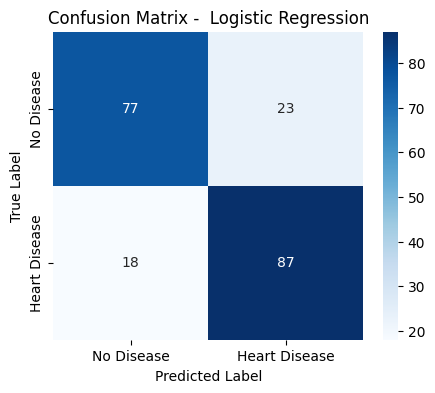

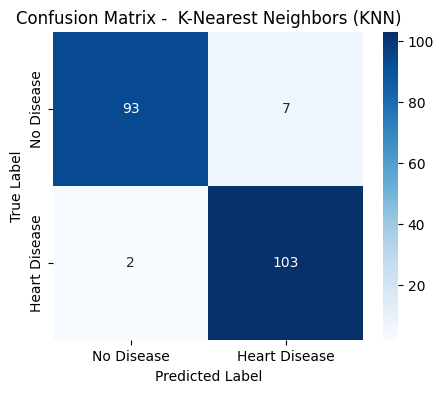

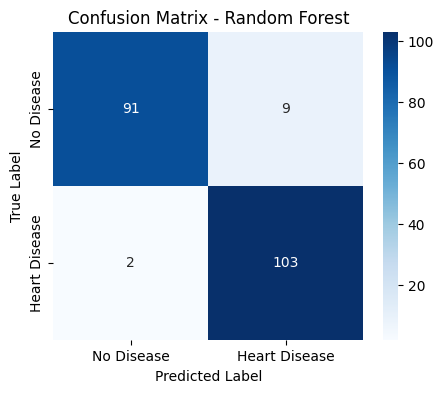

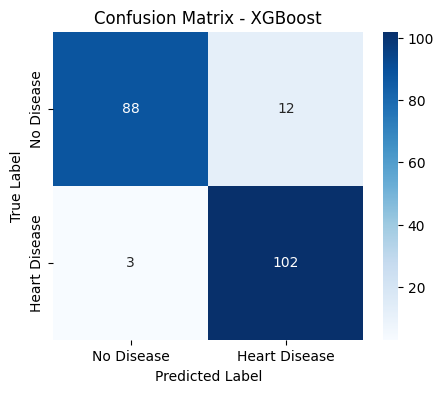

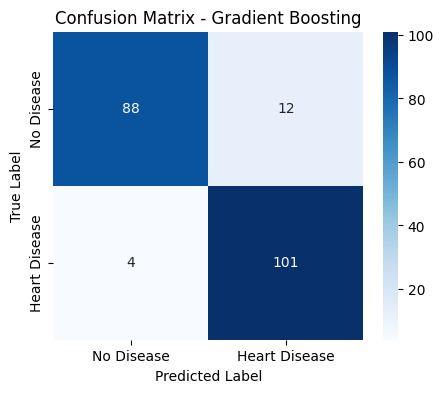

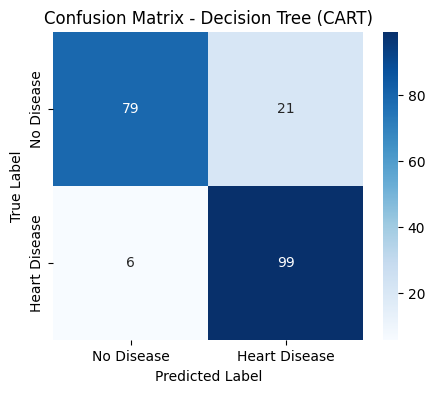

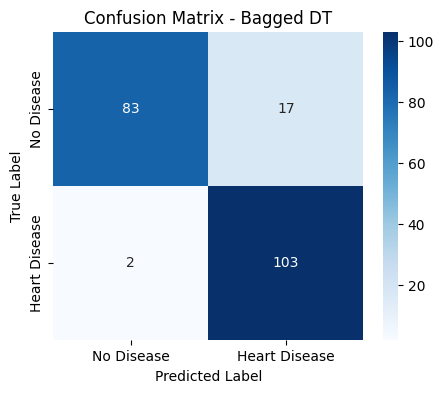

                        Model  Accuracy  Precision  Sensitivity (Recall)  \
0         Logistic Regression  0.800000   0.790909              0.828571   
1   K-Nearest Neighbors (KNN)  0.956098   0.936364              0.980952   
2               Random Forest  0.946341   0.919643              0.980952   
3                     XGBoost  0.926829   0.894737              0.971429   
4           Gradient Boosting  0.921951   0.893805              0.961905   
5        Decision Tree (CART)  0.868293   0.825000              0.942857   
6                   Bagged DT  0.907317   0.858333              0.980952   

   Specificity  F1 Score   ROC_AUC  Log_Loss  Matthews Corr  
0         0.77  0.809302  0.799286  7.208731       0.600002  
1         0.93  0.958140  0.955476  1.582404       0.913129  
2         0.91  0.949309  0.945476  1.934050       0.894538  
3         0.88  0.931507  0.925714  2.637340       0.856584  
4         0.88  0.926606  0.920952  2.813163       0.846105  
5         0.79  0.8

In [17]:
# Generate predictions using the tuned models
y_pred_logreg_best = logreg_best.predict(X_test_encoded)
y_pred_knn_best = knn_best.predict(X_test_encoded)
y_pred_rf_best = rf_best.predict(X_test_encoded)
y_pred_xgb_best = xgb_best.predict(X_test_encoded)
y_pred_gbm_best = gbm_best.predict(X_test_encoded)
y_pred_cart_best = cart_best.predict(X_test_encoded)
y_pred_bagging_best = bagging_best.predict(X_test_encoded)
# Store evaluation results
tuned_model_results = []

# Evaluate each tuned model
tuned_model_results.append(evaluate_model(y_test, y_pred_logreg_best, " Logistic Regression"))
tuned_model_results.append(evaluate_model(y_test, y_pred_knn_best, " K-Nearest Neighbors (KNN)"))
tuned_model_results.append(evaluate_model(y_test, y_pred_rf_best, "Random Forest"))
tuned_model_results.append(evaluate_model(y_test, y_pred_xgb_best, "XGBoost"))
tuned_model_results.append(evaluate_model(y_test, y_pred_gbm_best, "Gradient Boosting"))
tuned_model_results.append(evaluate_model(y_test, y_pred_cart_best, "Decision Tree (CART)"))
tuned_model_results.append(evaluate_model(y_test, y_pred_bagging_best, "Bagged DT" ))

# Create DataFrame for easy comparison
df_tuned_results = pd.DataFrame(tuned_model_results, 
                          columns=["Model", "Accuracy", "Precision", "Sensitivity (Recall)", 
                                   "Specificity", "F1 Score", "ROC_AUC", "Log_Loss", "Matthews Corr"])

# Display results
print(df_tuned_results)


# 7. Results

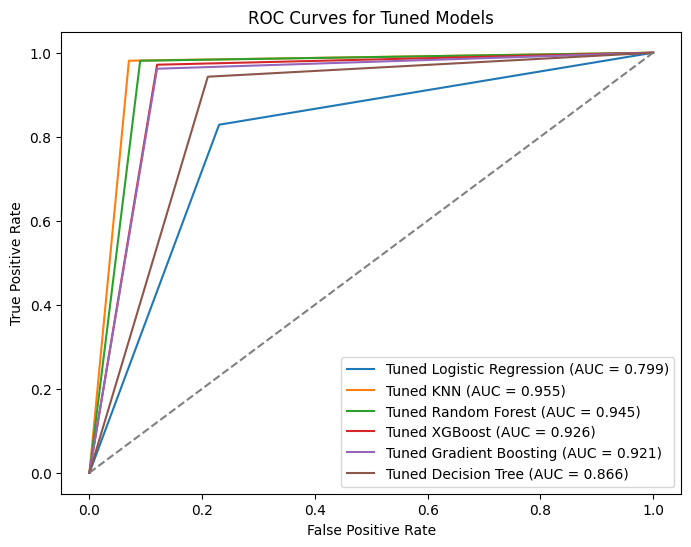

In [18]:
# Function to plot ROC curves
def plot_roc_curves(y_test, model_preds, model_names):
    plt.figure(figsize=(8, 6))
    
    for y_pred, model_name in zip(model_preds, model_names):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Tuned Models")
    plt.legend()
    plt.show()

# Call function with predictions
plot_roc_curves(y_test, 
                [y_pred_logreg_best, y_pred_knn_best, y_pred_rf_best, y_pred_xgb_best, y_pred_gbm_best, y_pred_cart_best], 
                ["Tuned Logistic Regression", "Tuned KNN", "Tuned Random Forest", "Tuned XGBoost", "Tuned Gradient Boosting", "Tuned Decision Tree"])


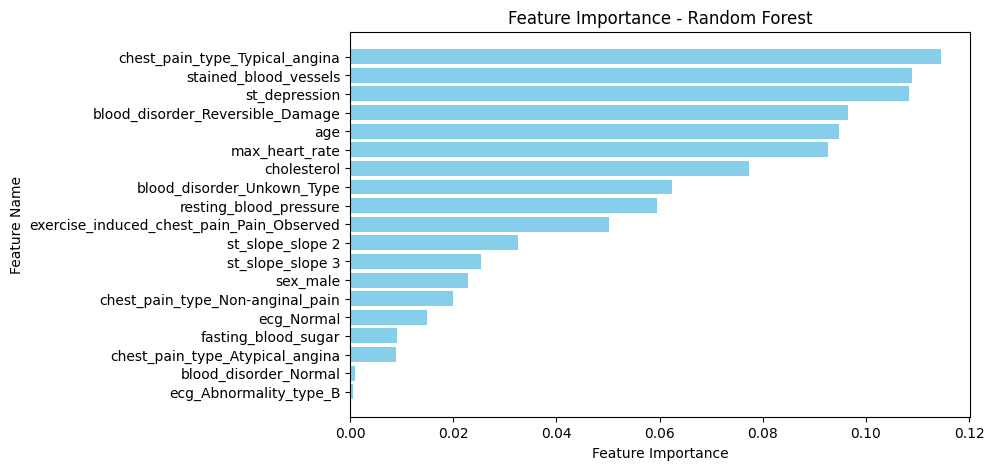

                                      Feature  Importance
10             chest_pain_type_Typical_angina    0.114494
6                       stained_blood_vessels    0.108910
5                               st_depression    0.108394
17           blood_disorder_Reversible_Damage    0.096630
0                                         age    0.094701
4                              max_heart_rate    0.092675
2                                 cholesterol    0.077293
18                 blood_disorder_Unkown_Type    0.062371
1                      resting_blood_pressure    0.059490
13  exercise_induced_chest_pain_Pain_Observed    0.050123


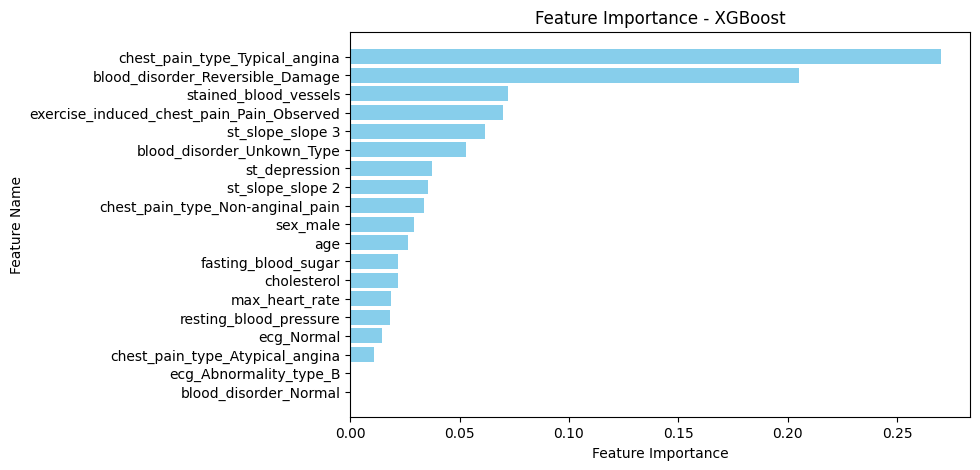

                                      Feature  Importance
10             chest_pain_type_Typical_angina    0.269830
17           blood_disorder_Reversible_Damage    0.205119
6                       stained_blood_vessels    0.072268
13  exercise_induced_chest_pain_Pain_Observed    0.070027
15                           st_slope_slope 3    0.061732
18                 blood_disorder_Unkown_Type    0.053033
5                               st_depression    0.037421
14                           st_slope_slope 2    0.035531
9            chest_pain_type_Non-anginal_pain    0.033795
7                                    sex_male    0.029099


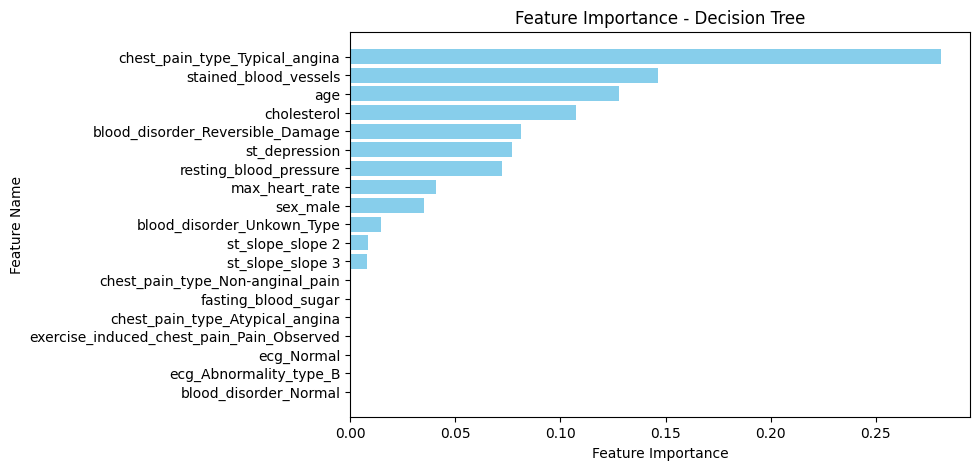

                             Feature  Importance
10    chest_pain_type_Typical_angina    0.280775
6              stained_blood_vessels    0.146443
0                                age    0.127861
2                        cholesterol    0.107544
17  blood_disorder_Reversible_Damage    0.081270
5                      st_depression    0.076869
1             resting_blood_pressure    0.072026
4                     max_heart_rate    0.040753
7                           sex_male    0.035259
18        blood_disorder_Unkown_Type    0.014668


In [19]:
# Extract feature importance
def plot_feature_importance(model, feature_names, model_name="Model"):
    importance = model.feature_importances_
    
    # Create DataFrame
    feat_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    
    # Sort by importance
    feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(feat_importance_df["Feature"], feat_importance_df["Importance"], color="skyblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()  # Highest at top
    plt.show()

    # Print top important features
    print(feat_importance_df.head(10))  # Top 10 most important features

# Plotting Random Forest 
plot_feature_importance(rf_best, X_train_encoded.columns, model_name="Random Forest")

# Plotting XGBoost
plot_feature_importance(xgb_best, X_train_encoded.columns, model_name="XGBoost")

# Plotting Decision Tree
plot_feature_importance(cart_best, X_train_encoded.columns, model_name="Decision Tree")


<h3> Chest Pain Type (Angina), Stained blood vessels, Blood Disorder Reversible damage, ST Depression, ST Slope (2 and 3), Max Heart Rate , Age, Cholesterol are some of the top features that aided in classification of heart disease </h3> 

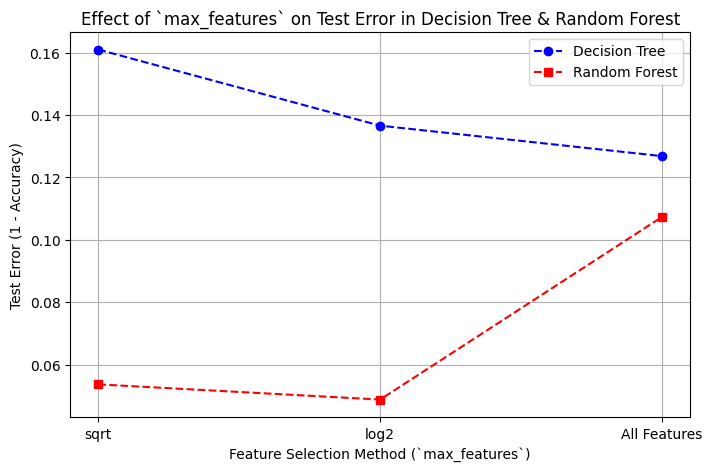

In [20]:
# Store test errors for max_features settings
dt_test_errors = {}
rf_test_errors = {}

# Iterate over max_features settings for Decision Tree
for feature_setting in ["sqrt", "log2", None]:
    dt_model = DecisionTreeClassifier(max_features=feature_setting)
    dt_model.fit(X_train_encoded, y_train_filtered)
    accuracy = dt_model.score(X_test_encoded, y_test)
    test_error = 1 - accuracy  # Test error = 1 - accuracy
    dt_test_errors[feature_setting] = test_error

# Iterate over max_features settings for Random Forest
for feature_setting in ["sqrt", "log2", None]:
    rf_model = RandomForestClassifier(max_features=feature_setting)
    rf_model.fit(X_train_encoded, y_train_filtered)
    accuracy = rf_model.score(X_test_encoded, y_test)
    test_error = 1 - accuracy  # Test error = 1 - accuracy
    rf_test_errors[feature_setting] = test_error

# Convert `None` to string for plotting
feature_settings = [str(f) if f is not None else "All Features" for f in dt_test_errors.keys()]
dt_errors = list(dt_test_errors.values())
rf_errors = list(rf_test_errors.values())


plt.figure(figsize=(8, 5))
plt.plot(feature_settings, dt_errors, marker='o', linestyle='dashed', label="Decision Tree", color='blue')
plt.plot(feature_settings, rf_errors, marker='s', linestyle='dashed', label="Random Forest", color='red')

# Labels
plt.xlabel("Feature Selection Method (`max_features`)")
plt.ylabel("Test Error (1 - Accuracy)")
plt.title("Effect of `max_features` on Test Error in Decision Tree & Random Forest")
plt.legend()
plt.grid(True)
plt.show()



Shows show considering all features for the best split reduces generalizibility and causes overfitting 

# 8. Conclusion

<h3> KNN is the best model (highest accuracy, best F1 score). Random Forest & XGBoost are slightly worse here but still strong. For real-world heart disease prediction (more patient data, more features), I would prefer XGBoost or Random Forest for better generalization. </h3>